In [19]:
import numpy as np

import scipy.io
import scipy.stats

import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns 

import itertools

#extend notebook
from IPython.core.display import display, HTML
display(HTML("<style>.container {width:99.5% !important;} </style>"))

# from tslearn.metrics import dtw as time_warping

import ordpy
import tqdm
import igraph

In [20]:
# from sklearn.cluster import SpectralClustering
# from sklearn.metrics import silhouette_score

# Functions' definitions

In [21]:
def stdfigsize(scale=1, nrows=1, ncols=1, ratio=1.3):
    """
    Returns a tuple to be used as figure size.

    Parameters
    ----------
    returns (7*ratio*scale*nrows, 7.*scale*ncols)
    By default: ratio=1.3
    ----------
    Returns (7*ratio*scale*nrows, 7.*scale*ncols).
    """

    return((7*ratio*scale*ncols, 7.*scale*nrows))

In [22]:
def normalize(array):
    """
    Normalizes an array between 0 and 1.
    """
    return (array-array.min())/(array.max()-array.min())

In [23]:
#https://github.com/oliviaguest/gini
#last modified 31/05/2020
def gini_faster(data):
    """
    Calculate the Gini coefficient of a numpy array.
    (Allegedly faster implementation to calculate
    the Gini index.)
     
    Parameters
    ----------
    data: list like object.
    ----------
    Returns the Gini index of a list of probabilities.    
    """
    # based on bottom eq: http://www.statsdirect.com/help/content/image/stat0206_wmf.gif
    # from: http://www.statsdirect.com/help/default.htm#nonparametric_methods/gini.htm

#Arthur (modified) line above
    array = np.asarray(data).flatten()
#     array = array.flatten() #all values are treated equally, arrays must be 1d
    if np.amin(array) < 0:
        array -= np.amin(array) #values cannot be negative
    array += 0.0000001 #values cannot be 0
    array = np.sort(array) #values must be sorted
    index = np.arange(1,array.shape[0]+1) #index per array element
    n = array.shape[0]#number of array elements
    return ((np.sum((2 * index - n  - 1) * array)) / (n * np.sum(array))) #Gini coefficient

def safe_avg_shortpath(ordnet):
    """
    Calculates the average weighted shortest 
    path for a graph removing possible
    infinities.
    
    Parameters
    ----------
    ordinal_network: return of the ordinal_network() function from the ordpy package.
    ----------
    Returns the average weighted shortest path
    calculated after the removal of eventual 
    infinities.
    """
    nodes, edges, weights = ordnet
    
    graph = igraph.Graph(directed=True)
    graph.add_vertices(nodes)
    graph.add_edges(edges)
    graph.vs["label"]  = nodes
    graph.es["weight"] = weights
    
    if not True in np.isinf(graph.shortest_paths(weights='weight')):
        w = np.asarray(graph.shortest_paths(weights='weight'))
        return w.mean()
    else:
        sp = np.asarray(graph.shortest_paths(weights='weight'))
        return np.mean(sp[sp<np.inf])

In [24]:
%matplotlib inline

#Style definitions
sns.set_style("white")
sns.set_style({"xtick.direction": "out", "ytick.direction": "out"})

rcparams = {
    'font.family': 'sans-serif',
    'font.sans-serif': ['Helvetica'],
    'axes.labelsize': 28,
    'axes.titlesize': 28,
    'legend.fontsize': 20,
    'ytick.right': 'off',
    'xtick.top': 'off',
    'ytick.left': 'on',
    'xtick.bottom': 'on',
    'xtick.labelsize': '25',
    'ytick.labelsize': '25',
    'axes.linewidth': 2.5,
    'xtick.major.width': 1.8,
    'xtick.minor.width': 1.8,
    'xtick.major.size': 14,
    'xtick.minor.size': 7,
    'xtick.major.pad': 10,
    'xtick.minor.pad': 10,
    'ytick.major.width': 1.8,
    'ytick.minor.width': 1.8,
    'ytick.major.size': 14,
    'ytick.minor.size': 7,
    'ytick.major.pad': 10,
    'ytick.minor.pad': 10,
    'axes.labelpad': 15,
    'axes.titlepad': 15,
    'axes.spines.right': False,
    'axes.spines.top': False,
    'figure.figsize': stdfigsize(),
    'lines.linewidth': 3
}
mpl.rcParams.update(rcparams)

In [25]:
def multi_permutation_entropy(data, dx=3, taux=1, base=2, normalized=True, return_probs=False):
    """
    Calculates Shannon's entropy using an ordinal ditribution extracted from
    data (a multidimensional time series).
    
    Parameters
    ----------
    data : array
           Array object in the format :math:`[[x_{11}, x_{12}, x_{13}, \\ldots, x_{1m}],
           \\ldots, [x_{n1}, x_{n2}, x_{n3}, \\ldots, x_{nm}]]` where n is the length 
           and m is the dimension of a multidimensional time series.
    dx : int
         Embedding dimension (horizontal axis) (default: 3)
    taux : int
           Embedding delay (horizontal axis) (default: 1).
    base : str, int
           Logarithm base in Shannon's entropy. Either 'e' or 2 (default: 'e').
    normalized: boolean
                If `True`, permutation entropy is normalized by its maximum value.
                If `False`, it does not (default: `True`).

    Returns
    -------
     : float
       The value of permutation entropy.
    
    Examples
    --------
    """
    try:
        ny, nx = np.shape(data)
        data   = np.array(data).T
    except:
        return None
    
    partitions              = [np.concatenate([[component[i:i+dx*taux:taux]] for i in range(ny-(dx-1)*taux)]) for component in data]
    flat_symbolic_sequences = np.apply_along_axis(np.argsort, 2, partitions).reshape(-1, dx)
    _, symbols_count        = np.unique(flat_symbolic_sequences, return_counts=True, axis=0)

    probabilities = symbols_count/symbols_count.sum()
    
    if return_probs==True:
        miss_symbols  = np.math.factorial(dx)-len(probabilities)
        probabilities = np.concatenate((probabilities, np.zeros(miss_symbols)))
        
        return probabilities
    
    else:
        if normalized==True and base in [2, '2']:        
            smax = np.log2(np.math.factorial(dx))
            s    = -np.sum(probabilities*np.log2(probabilities))
            return s/smax

        elif normalized==True and base=='e':        
            smax = np.log(np.math.factorial(dx))
            s    = -np.sum(probabilities*np.log(probabilities))
            return s/smax

        elif normalized==False and base in [2, '2']:
            return -np.sum(probabilities*np.log2(probabilities))

        else:
            return -np.sum(probabilities*np.log(probabilities))

In [26]:
def mwpe(data, dx=3, taux=1, base=2, normalized=True, return_probs=False):
    """
    Multivariate weighted permutation entropy.
    
    Parameters
    ----------
    data : array
           Array object in the format :math:`[[x_{11}, x_{12}, x_{13}, \\ldots, x_{1m}],
           \\ldots, [x_{n1}, x_{n2}, x_{n3}, \\ldots, x_{nm}]]` where n is the length 
           and m is the dimension of a multidimensional time series.
    dx : int
         Embedding dimension (horizontal axis) (default: 3)
    taux : int
           Embedding delay (horizontal axis) (default: 1).
    base : str, int
           Logarithm base in Shannon's entropy. Either 'e' or 2 (default: 'e').
    normalized: boolean
                If `True`, permutation entropy is normalized by its maximum value.
                If `False`, it does not (default: `True`).

    Returns
    -------
     : float
       The value of permutation entropy.
    
    Examples
    --------
    """
    try:
        ny, nx = np.shape(data)
        data   = np.array(data).T
    except:
        return None
    
    partitions              = np.asarray([np.concatenate([[component[i:i+dx*taux:taux]] for i in range(ny-(dx-1)*taux)]) for component in data])
    weights                 = partitions.var(axis=2).flatten()
    flat_symbolic_sequences = np.apply_along_axis(np.argsort, 2, partitions).reshape(-1, dx)
    symbols                 = np.unique(flat_symbolic_sequences, return_counts=False, axis=0)


    total_variance = []
    for symbol in symbols:
        z    = flat_symbolic_sequences==symbol
        z    = z.sum(axis=1)
        args = np.argwhere(z==dx).flatten()
        
        total_variance.append(sum(weights[args]))

    probabilities = total_variance/sum(total_variance)
    
    if return_probs==True:
        miss_symbols  = np.math.factorial(dx)-len(probabilities)
        probabilities = np.concatenate((probabilities, np.zeros(miss_symbols)))
        
        return probabilities
    
    else:
        if normalized==True and base in [2, '2']:        
            smax = np.log2(np.math.factorial(dx))
            s    = -np.sum(probabilities*np.log2(probabilities))
            return s/smax

        elif normalized==True and base=='e':        
            smax = np.log(np.math.factorial(dx))
            s    = -np.sum(probabilities*np.log(probabilities))
            return s/smax

        elif normalized==False and base in [2, '2']:
            return -np.sum(probabilities*np.log2(probabilities))

        else:
            return -np.sum(probabilities*np.log(probabilities))   

In [27]:
def weighted_permutation_entropy(data, dx=3, taux=1, base=2, normalized=True):
    """
    Multivariate weighted permutation entropy.
    
    Parameters
    ----------
    data : array
           Array object in the format :math:`[[x_{11}, x_{12}, x_{13}, \\ldots, x_{1m}],
           \\ldots, [x_{n1}, x_{n2}, x_{n3}, \\ldots, x_{nm}]]` where n is the length 
           and m is the dimension of a multidimensional time series.
    dx : int
         Embedding dimension (horizontal axis) (default: 3)
    taux : int
           Embedding delay (horizontal axis) (default: 1).
    base : str, int
           Logarithm base in Shannon's entropy. Either 'e' or 2 (default: 'e').
    normalized: boolean
                If `True`, permutation entropy is normalized by its maximum value.
                If `False`, it does not (default: `True`).

    Returns
    -------
     : float
       The value of permutation entropy.
    
    Examples
    --------
    """
    data   = np.asrray(data)
    
    partitions              = np.asarray([np.concatenate([[component[i:i+dx*taux:taux]] for i in range(ny-(dx-1)*taux)]) for component in data])
    weights                 = partitions.var(axis=2).flatten()
    flat_symbolic_sequences = np.apply_along_axis(np.argsort, 2, partitions).reshape(-1, dx)
    symbols                 = np.unique(flat_symbolic_sequences, return_counts=False, axis=0)


    total_variance = []
    for symbol in symbols:
        z    = flat_symbolic_sequences==symbol
        z    = z.sum(axis=1)
        args = np.argwhere(z==dx).flatten()
        
        total_variance.append(sum(weights[args]))

    probabilities = total_variance/sum(total_variance)
    
    if return_probs==True:
        miss_symbols  = np.math.factorial(dx)-len(probabilities)
        probabilities = np.concatenate((probabilities, np.zeros(miss_symbols)))
        
        return probabilities
    
    else:
        if normalized==True and base in [2, '2']:        
            smax = np.log2(np.math.factorial(dx))
            s    = -np.sum(probabilities*np.log2(probabilities))
            return s/smax

        elif normalized==True and base=='e':        
            smax = np.log(np.math.factorial(dx))
            s    = -np.sum(probabilities*np.log(probabilities))
            return s/smax

        elif normalized==False and base in [2, '2']:
            return -np.sum(probabilities*np.log2(probabilities))

        else:
            return -np.sum(probabilities*np.log(probabilities))   

# Disks

<p style="font-size=200px;"><b>Classification:</b></p>

1) Tumbling

2) Chaotic

3) Steady or periodic behavior</p>

In [110]:
shape = 'Square'

disk_human_class = scipy.io.loadmat('classification/humanClassification{}.mat'.format(shape))['behaviourHuman'][0]
disk_feat_class  = scipy.io.loadmat('classification/data{}Classified.mat'.format(shape))['behaviourAuto'].flatten()

#Improving data structure. Extracting data from dataCircle.mat and loading it into data arrays
disk_data = scipy.io.loadmat('classification/data{}.mat'.format(shape))

In [98]:
#initial condition of the experiments: 0 (dropping with arm holding the paper horizontally) or 1 (dropping vertically)
disk_initcons = []
for i in range(len(disk_data['data'][0])):
    disk_initcons.append(disk_data['data'][0][i]['initialCondition'][0][0][0][0])
disk_initcons = np.asarray(disk_initcons)

# radii of the disks dropped
disk_radii = []
for i in range(len(disk_data['data'][0])):
    disk_radii.append(disk_data['data'][0][i]['radius'][0][0][0][0])
disk_radii = np.asarray(disk_radii)

# camera 1 observable area?
disk_cam1 = []
for i in range(len(disk_data['data'][0])):
    disk_cam1.append(disk_data['data'][0][i]['areaCam1'][0][0].flatten())
disk_cam1 = np.asarray(disk_cam1)

# camera 2 observable area?
disk_cam2 = []
for i in range(len(disk_data['data'][0])):
    disk_cam2.append(disk_data['data'][0][i]['areaCam2'][0][0].flatten())
disk_cam2 = np.asarray(disk_cam2)

# coordinates (x, y, z) along trajectory from 1m high to the floor.
disk_trajectories = []
for i in range(len(disk_data['data'][0])):
    disk_trajectories.append(disk_data['data'][0][i]['trajectory'][0][0])
disk_trajectories = np.asarray(disk_trajectories)

clean_disk_trajectories = []
clean_disk_initcons     = []
clean_disk_class        = []
clean_disk_radii        = []
clean_disk_cam2         = []
clean_disk_cam1         = []

for i in range(len(disk_trajectories)):
    #vertical trajectory
    z                = disk_trajectories[i][::,2]
    # removing the last 5 centimeters of the fall.
    trajectory       = disk_trajectories[i][z>.05]
    
    #removing from area series, the last 5cm of the fall
    cut_5pc   = len(z)-len(z[z>.05])
    area_cam2 = disk_cam2[i][:-cut_5pc]
    area_cam1 = disk_cam1[i][:-cut_5pc]

#(original comment) Segment steady and periodic behaviours from trajectories. 
#We only see steady and periodic from horizontal initial condition.
    if disk_initcons[i]==0:        
        boolean_trajectory = np.sqrt(trajectory[::,0]**2 + trajectory[::,1]**2)<.2*disk_radii[i]
        steady_index       = boolean_trajectory.tolist().index(False)

        if steady_index>1: #(original comment) Segment trajectory into steady(periodic)/unknown if more than 2 time-steps are steady(periodic)
#             pass
#             print(steady_index)
            clean_disk_trajectories.append(trajectory[:steady_index])
            clean_disk_initcons.append(0)
            clean_disk_radii.append(disk_radii[i])
            clean_disk_class.append(3)
            clean_disk_cam1.append(area_cam1[:steady_index])
            clean_disk_cam2.append(area_cam2[:steady_index])
            
            if len(trajectory[steady_index:])>10: #second part of the sliced original trajectory.
                clean_disk_trajectories.append(trajectory[steady_index:])
                clean_disk_initcons.append(0)
                clean_disk_radii.append(disk_radii[i])
                clean_disk_class.append(np.nan)
                clean_disk_cam1.append(area_cam1[steady_index:])
                clean_disk_cam2.append(area_cam2[steady_index:])
                
                
            else: pass
        
        else: #no segmentation; only one behavior through the whole fall
            clean_disk_trajectories.append(trajectory[steady_index:])
            clean_disk_initcons.append(0)
            clean_disk_radii.append(disk_radii[i])
            clean_disk_class.append(np.nan)
            clean_disk_cam1.append(area_cam1[steady_index:])
            clean_disk_cam2.append(area_cam2[steady_index:])
                
    else: #no trajectory segmentation
        boolean_trajectory = np.sqrt(trajectory[::,0]**2 + trajectory[::,1]**2)<0.01
        cut_index          = boolean_trajectory.tolist().index(False)
        
        if len(trajectory[cut_index:])>10: #second part of the sliced original trajectory.
            clean_disk_trajectories.append(trajectory[cut_index:])
            clean_disk_initcons.append(1)
            clean_disk_radii.append(disk_radii[i])
            clean_disk_class.append(np.nan)
            clean_disk_cam1.append(area_cam1[cut_index:])
            clean_disk_cam2.append(area_cam2[cut_index:])

# np.save('pickles/clean_disk_trajectories.npy', clean_disk_trajectories)
# np.save('pickles/clean_disk_initcons.npy', clean_disk_initcons)    
# np.save('pickles/clean_disk_class.npy', clean_disk_class)       
# np.save('pickles/clean_disk_radii.npy', clean_disk_radii)       
# np.save('pickles/clean_disk_class.npy', clean_disk_class)       

In [50]:
#PLOTTING RÈNYI OR TSALLIS CURVES
# dx_ = 4

# for i in tqdm.tqdm(range(len(clean_disk_trajectories))):
#     if not clean_disk_class[i]==3:    
#         ts     = np.stack((normalize(clean_disk_cam1[i]), normalize(clean_disk_cam2[i])), axis=1)
#         p      = multi_permutation_entropy(ts, dx=dx_, return_probs=True)
#         data   = np.asarray(ordpy.renyi_complexity_entropy(p, dx=dx_, alpha=np.logspace(-3, 2, num=100), probs=True))
#         h_, c_ = data.T
#         #
#         #
#         f, ax  = plt.subplots()
#         if disk_human_class[i]==1:
#             ax.plot(h_, c_, '-', color='#C05A3C', label='Tumbling')
#         if disk_human_class[i]==2:
#             ax.plot(h_, c_, '-', color='#3888BA', label='Chaotic')
            
#         ax.set_ylabel(r'Statistical complexity, $C$')
#         ax.set_xlabel(r'Permutation entropy, $H$')
#         ax.legend(frameon=True)
        
#         f.tight_layout()
#         f.savefig('figures/sample-{}-renyi(cam1).svg'.format(i), bbox_inches='tight')
#         plt.close()
        
#     else:
#         pass

In [75]:
#3D plotting
# from mpl_toolkits.mplot3d import Axes3D

# fig = plt.figure()
# ax  = fig.gca(projection='3d')

# h1, h2 = np.asarray(disk_ce).T

# for pe_,h1_,h2_,  class_ in zip(pe,h1,h2,disk_human_class):
#     if class_ == 1:
#         ax.scatter(pe_, h1_, h2_, '.', marker='*', color='grey')
#     elif class_ == 2:
#         ax.scatter(pe_, h1_, h2_,  '.', marker='*', color='blue')
#     if class_ == 3:
#         pass

# plt.show()

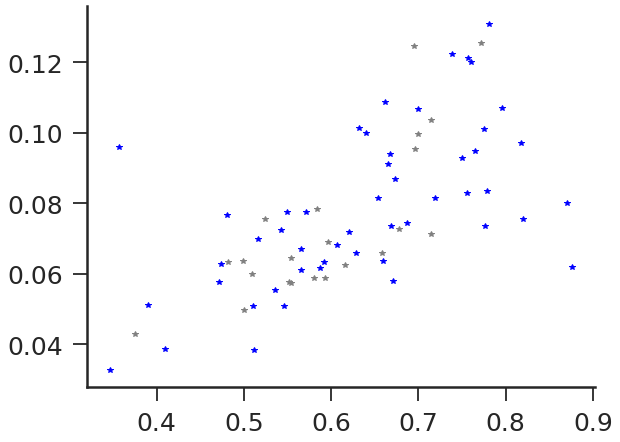

In [115]:
# for ts in clean_disk_trajectories:
#     disk_ce.append(mwpe(ts, dx=4))

dx_     = 4
disk_ce = []    
for ts, ts1, ts2, class_ in zip(clean_disk_trajectories, clean_disk_cam1, clean_disk_cam2, clean_disk_class):
    if class_==3:
        disk_ce.append((np.nan, np.nan))
    else:
#         ts = np.stack((normalize(ts1), normalize(ts2)), axis=1)
#         ts1 =  normalize(ts1)
#         print(i)
#         ts = np.diff(ts, axis=0)
#         p  = multi_permutation_entropy(ts, dx=dx_, return_probs=True)
#         p2 = mwpe(ts, dx=dx_, return_probs=True)
#         disk_ce.append(ordpy.complexity_entropy(p, dx=dx_, probs=True))
#         disk_ce.append([p, p2])
        ordnet = ordpy.ordinal_network(normalize(ts1), dx=dx_)
        path_  = safe_avg_shortpath(ordnet)
        disk_ce.append([ordpy.global_node_entropy(ordnet, dx=dx_), path_])

# for i, h_, class_ in zip(range(len(disk_ce)), disk_ce, disk_human_class):
#     if class_ == 1:
#         plt.plot(i, h_, '.', marker='*', color='grey')
#     elif class_ == 2:
#         plt.plot(i, h_, '.', marker='*', color='blue')
#     if class_ == 3:
#         pass

# disk_feat_class['behaviourAuto'].flatten()
# for (h_, c_), class_ in zip(disk_ce, disk_human_class):
for (h_, c_), class_ in zip(disk_ce, disk_feat_class): 
    if class_ == 1:
        plt.plot(h_, c_, '.', marker='*', color='grey')
    elif class_ == 2:
        plt.plot(h_,c_,  '.', marker='*', color='blue', zorder=0)
    if class_ == 3:
        pass

In [116]:
# for i in tqdm.tqdm(range(len(clean_disk_trajectories))):

#     f, ax = plt.subplots()
#     x_, z_ = clean_disk_trajectories[i][::,0], clean_disk_trajectories[i][::,2]
    
#     ax.plot(x_, z_, '-', color='grey')
#     ax.set_ylabel('z, altura')
#     ax.set_xlabel('x, lateral')
    
#     ax.vlines(x=0, ymin=0, ymax=1, linestyle='--', zorder= 0)

#     f.tight_layout()
#     f.savefig('figures/{}cross.svg'.format(i), bbox_inches='tight')
#     plt.close()

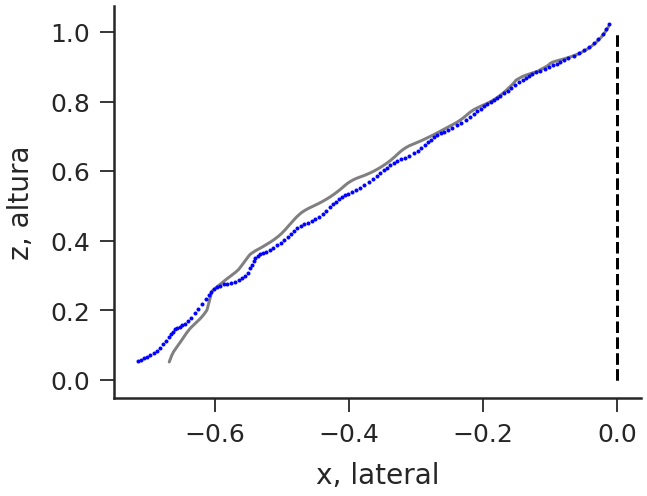

In [208]:
# for i in tqdm.tqdm(range(len(clean_disk_trajectories))):

f, ax = plt.subplots()
for i in [21,6]:
    if i==21:
        x_, z_ = clean_disk_trajectories[i][::,0], clean_disk_trajectories[i][::,2]
        ax.plot(x_, z_, '-', color='grey')
    else:
        x_, z_ = clean_disk_trajectories[i][::,0], clean_disk_trajectories[i][::,2]
        ax.plot(x_, z_, '.', color='blue')

    ax.vlines(x=0, ymin=0, ymax=1, linestyle='--', zorder= 0)
    ax.set_ylabel('z, altura')
    ax.set_xlabel('x, lateral')

    f.tight_layout()
# f.savefig('figures/{}.svg'.format(i), bbox_inches='tight')
# plt.close()

In [261]:
# 21seconds to run.
dtw_matrix = []
ts         = rev_disk_trajectories
A          = range(ts.__len__())

k          = ts.__len__()
dtw_matrix = []
for i,j in list(itertools.product(A, A)):
    ts1 = scipy.stats.zscore(ts[i][::,0::2], axis=0)
    ts2 = scipy.stats.zscore(ts[j][::,0::2], axis=0)
    dtw_matrix.append(time_warping(ts1, ts2))
dtw_matrix = np.reshape(dtw_matrix, (170,-1))

In [230]:
def check_symmetric(a, tol=1e-8):
    """Checks if matrix is symmetric."""
    return np.all(np.abs(a-a.T) < tol)

# Hexagons

# Squares

# Crosses